In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd drive/MyDrive/ExamProject

[Errno 2] No such file or directory: 'drive/MyDrive/ExamProject'
/content/drive/MyDrive/ExamProject


In [ ]:
#!ls

In [ ]:
from yolov3_the_model_withpretrainedweight import YOLOv3
from yolo_dataset import YOLODataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import torch
from torch.utils.data import DataLoader

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
##the anchors that was calculated using k-means
ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
] 
#the dataset
DATASET = 'PASCAL_VOC'
IMAGE_SIZE = 416
scale = 1.1
IMG_DIR = DATASET + "/images/"
LABEL_DIR = DATASET + "/labels/"
NUM_WORKERS = 4
BATCH_SIZE = 32
PIN_MEMORY = True
#scaler to scale images
S = [IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8] #13 26 52
NUM_EPOCHS = 10
#pascal classes
PASCAL_CLASSES = [
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor"
]


In [ ]:
train_transforms = A.Compose(
    [
     #Rescale an image so that maximum side is equal to max_size, keeping the aspect ratio of the initial image.
     A.LongestMaxSize(max_size=int(IMAGE_SIZE * scale)),
     #adding pad if the if side is less than desired number
     A.PadIfNeeded(
         min_height=int(IMAGE_SIZE * scale),
         min_width=int(IMAGE_SIZE * scale),
         border_mode=cv2.BORDER_CONSTANT,
         ),
     #Crop a random part of the input.
     A.RandomCrop(width=IMAGE_SIZE, height=IMAGE_SIZE),
     #Randomly changes the brightness, contrast, and saturation of an image
     A.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
     A.OneOf(
         [
          #randomly translate, scale and rotate the input.
          A.ShiftScaleRotate(rotate_limit=10, p=0.4, border_mode=cv2.BORDER_CONSTANT),
          #Place a regular grid of points on the input and randomly move the neighbourhood of these point around
          A.IAAAffine(shear=10, p=0.4, mode="constant"),
          ],p=1.0,),
     A.HorizontalFlip(p=0.5),
     A.Blur(p=0.1),
     #Apply Contrast Limited Adaptive Histogram Equalization to the input image
     A.CLAHE(p=0.1),
     #Reduce the number of bits for each color channel.
     A.Posterize(p=0.1),
     A.ToGray(p=0.1),
     #Randomly rearrange channels of the input RGB image.
     A.ChannelShuffle(p=0.05),
     A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
     ToTensorV2(),],
     bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[],),
)
test_transforms = A.Compose(
    [
        A.LongestMaxSize(max_size=IMAGE_SIZE),
        A.PadIfNeeded(
            min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
        ),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[]),
)


/usr/local/lib/python3.8/dist-packages/albumentations/imgaug/transforms.py:348: FutureWarning: This IAAAffine is deprecated. Please use Affine instead
  warnings.warn("This IAAAffine is deprecated. Please use Affine instead", FutureWarning)


In [ ]:
#number of classes equal 20 so the model can work with pascal dataset
model = YOLOv3(num_classes = 20).to(DEVICE)

our weights on 10 epoch 

https://drive.google.com/file/d/1RfgHBJWeKrbL9OnrYblTYiL2hENtpVwP/view?usp=sharing

In [ ]:
checkpoint = torch.load("checkpoint.pth.tar", map_location=DEVICE)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

our weights on 100 epoch

https://drive.google.com/file/d/1awYu9Y96fEXjNB7SV35SHygJ1o_jEk22/view?usp=share_link

In [ ]:
# checkpoint = torch.load("Weights/checkpoint.pth.tar"", map_location=DEVICE)
# model.load_state_dict(checkpoint["state_dict"])

COCO predifined Weights from the official website for the paper.

https://pjreddie.com/darknet/yolo/

In [ ]:
#model.load_darknet_weights(weights_path="Weights/yolov3.weights")

In [ ]:
#this function returns dataloaders(weither train loaders or test loaders) for a specific dataset using yoloDataSet python code
def get_loaders(train_csv_path, test_csv_path):
  IMAGE_SIZE = 416
  train_dataset = YOLODataset(
      train_csv_path,
      transform=train_transforms,
      S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
      img_dir=IMG_DIR,
      label_dir=LABEL_DIR,
      anchors=ANCHORS,
  )
  test_dataset = YOLODataset(
      test_csv_path,
      transform= test_transforms,
      S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
      img_dir=IMG_DIR,
      label_dir=LABEL_DIR,
      anchors=ANCHORS,
  )
  train_loader = DataLoader(
      dataset=train_dataset,
      batch_size=BATCH_SIZE,
      num_workers=NUM_WORKERS,
      pin_memory=PIN_MEMORY,
      shuffle=False,
      drop_last=False,
  )
  test_loader = DataLoader(
      dataset=test_dataset,
      batch_size=BATCH_SIZE,
      num_workers=NUM_WORKERS,
      pin_memory=PIN_MEMORY,
      shuffle=False,
      drop_last=False,
  )
  train_eval_dataset = YOLODataset(
      train_csv_path,
      transform=test_transforms,
      S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8],
      img_dir=IMG_DIR,
      label_dir=LABEL_DIR,
      anchors=ANCHORS,
  )
  train_eval_loader = DataLoader(
      dataset=train_eval_dataset,
      batch_size=BATCH_SIZE,
      num_workers=NUM_WORKERS,
      pin_memory=PIN_MEMORY,
      shuffle=False,
      drop_last=False,
  )
  return train_loader, test_loader, train_eval_loader

In [ ]:
#getting train/test loaders on a subset of the dataset.
train_loader, test_loader, train_eval_loader = get_loaders(train_csv_path=DATASET + "/100examples.csv", test_csv_path=DATASET + "/100examples.csv")

In [ ]:
scaled_anchors = (torch.tensor(ANCHORS)* torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)).to(DEVICE)

###### helper functions

In [ ]:
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from non_max_suppression import nms
import numpy as np
import matplotlib.patches as patches

In [ ]:
#This function scales the predictions from the output of the model so it would be relative for the input image (helps with plotting)
def cells_to_bboxes(predictions, anchors, S, is_preds=True):
#   This function takes as parametes:
#     1-predictions: tensor of size (N, 3, S, S, num_classes+5)
#     2-anchors: used in predictions phase
#     3-S the number of cells the image is divided in on the width (and height)
#     4-is_preds: wether the input is predictions or ground_truth bboxes (which means it can be used to with data directly from the dataSet)
#   And returns Converted_bboxes which is converted bboxes with sizes (N, num_anchors, S, S, 1+5) , the number 6 is [class_index, Object_score,bbox cordinates]
  BATCH_SIZE = predictions.shape[0]
  num_anchors = len(anchors)
  box_predictions = predictions[..., 1:5]
  if is_preds:
      anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
      box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
      box_predictions[..., 2:] = torch.exp(box_predictions[..., 2:]) * anchors
      scores = torch.sigmoid(predictions[..., 0:1])
      best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1)
  else:
      scores = predictions[..., 0:1]
      best_class = predictions[..., 5:6]

  cell_indices = (
      torch.arange(S)
      .repeat(predictions.shape[0], 3, S, 1)
      .unsqueeze(-1)
      .to(predictions.device)
  )
  x = 1 / S * (box_predictions[..., 0:1] + cell_indices)
  y = 1 / S * (box_predictions[..., 1:2] + cell_indices.permute(0, 1, 3, 2, 4))
  w_h = 1 / S * box_predictions[..., 2:4]
  converted_bboxes = torch.cat((best_class, scores, x, y, w_h), dim=-1).reshape(BATCH_SIZE, num_anchors * S * S, 6)
  return converted_bboxes.tolist()

In [ ]:
#A function to print an image with it's bounding boxes
def plot_image(image, boxes):
  cmap = plt.get_cmap("tab20b")
  #This line can be changed depending on the DataSet 
  class_labels = PASCAL_CLASSES
  colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
  im = np.array(image)
  height, width, _ = im.shape
  # Create figure and axes
  fig, ax = plt.subplots(1)
  # Display the image
  ax.imshow(im,aspect='auto')
  # box[0] is x midpoint, box[2] is width
  # box[1] is y midpoint, box[3] is height
  # Create a Rectangle patch
  for box in boxes:
      assert len(box) == 6, "box should contain class pred, confidence, x, y, width, height"
      class_pred = box[0]
      box = box[2:]
      upper_left_x = box[0] - box[2] / 2
      upper_left_y = box[1] - box[3] / 2
      rect = patches.Rectangle(
          (upper_left_x * width, upper_left_y * height),
          box[2] * width,
          box[3] * height,
          linewidth=2,
          edgecolor=colors[int(class_pred)],
          facecolor="none",
      )
      # Add the patch to the Axes
      ax.add_patch(rect)
      plt.text(
          upper_left_x * width,
          upper_left_y * height,
          s=class_labels[int(class_pred)],
          color="white",
          verticalalignment="top",
          bbox={"color": colors[int(class_pred)], "pad": 0},
      )

  plt.show()


#Main Testing

In [ ]:
def plot_Test(model, loader, thresh, iou_thresh, anchors):
  model.eval()
  x, y = next(iter(loader))
  x = x.to("cuda")
  with torch.no_grad():
      out = model(x)
      bboxes = [[] for _ in range(x.shape[0])]
      for i in range(3):
          batch_size, A, S, _, _ = out[i].shape
          anchor = anchors[i]
          boxes_scale_i = cells_to_bboxes(out[i], anchor, S=S, is_preds=True)
          for idx, (box) in enumerate(boxes_scale_i):
              bboxes[idx] += box
      model.train()
  for i in range(batch_size):
      nms_boxes = nms(bboxes[i], iou_threshold=iou_thresh, threshold=thresh, box_format="midpoint",)
      plot_image(x[i].permute(1,2,0).detach().cpu(), nms_boxes)

In [ ]:
def get_evaluation_bboxes(
  loader,
  model,
  iou_threshold,
  anchors,
  threshold,
  box_format="midpoint",
  device="cuda",
):
  # make sure model is in eval before get bboxes
  model.eval()
  train_idx = 0
  all_pred_boxes = []
  all_true_boxes = []
  for batch_idx, (x, labels) in enumerate(tqdm(loader)):
      x = x.to(device)

      with torch.no_grad():
          predictions = model(x)

      batch_size = x.shape[0]
      bboxes = [[] for _ in range(batch_size)]
      for i in range(3):
          S = predictions[i].shape[2]
          anchor = torch.tensor([*anchors[i]]).to(device) * S
          boxes_scale_i = cells_to_bboxes(
              predictions[i], anchor, S=S, is_preds=True
          )
          for idx, (box) in enumerate(boxes_scale_i):
              bboxes[idx] += box

      # we just want one bbox for each label, not one for each scale
      true_bboxes = cells_to_bboxes(
          labels[2], anchor, S=S, is_preds=False
      )

      for idx in range(batch_size):
          nms_boxes = nms(
              bboxes[idx],
              iou_threshold=iou_threshold,
              threshold=threshold,
              box_format=box_format,
          )

          for nms_box in nms_boxes:
              all_pred_boxes.append([train_idx] + nms_box)

          for box in true_bboxes[idx]:
              if box[1] > threshold:
                  all_true_boxes.append([train_idx] + box)

          train_idx += 1

  model.train()
  return all_pred_boxes, all_true_boxes


In [ ]:
from mean_average_precision import mean_average_precision

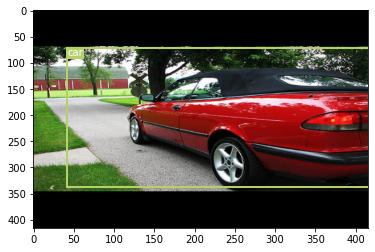

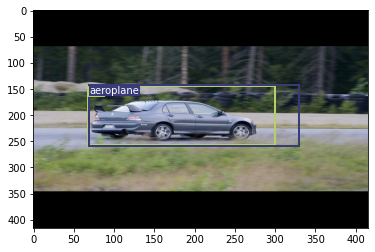

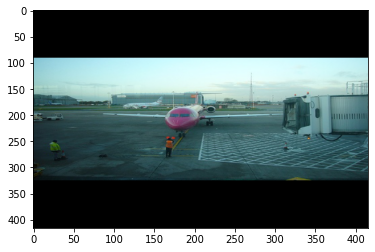

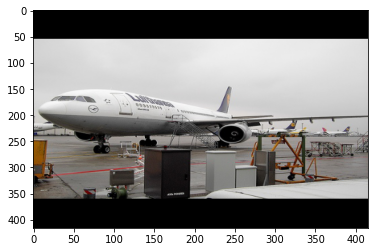

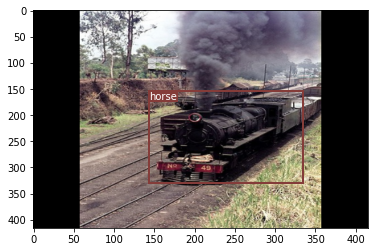

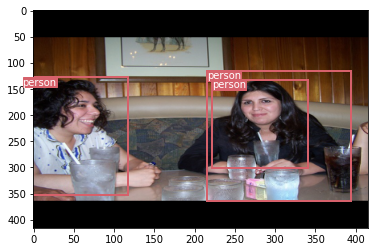

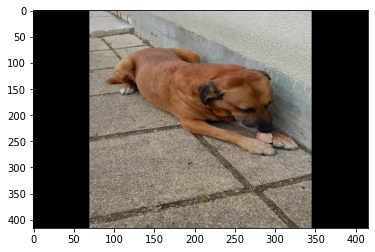

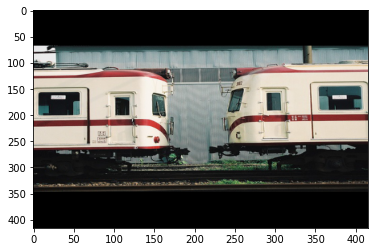

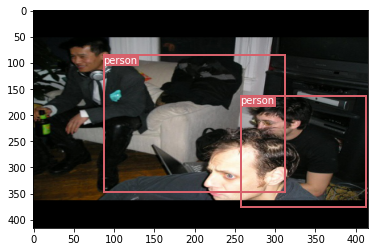

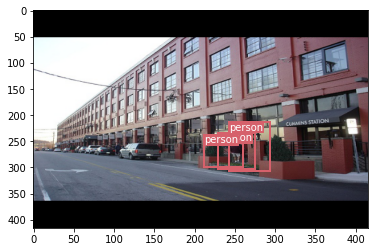

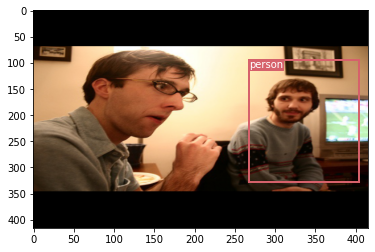

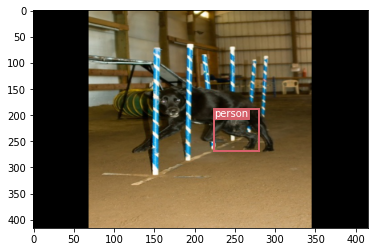

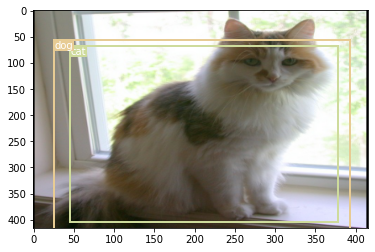

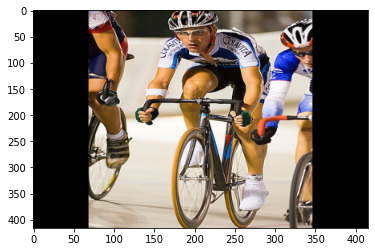

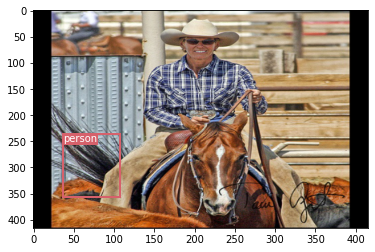

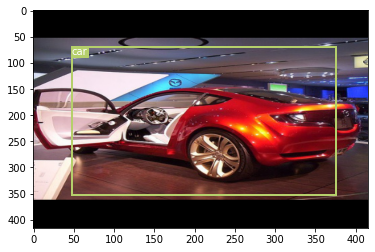

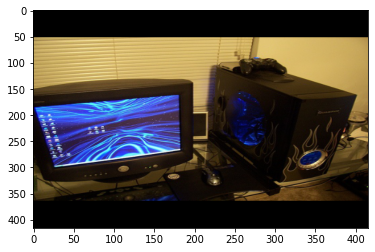

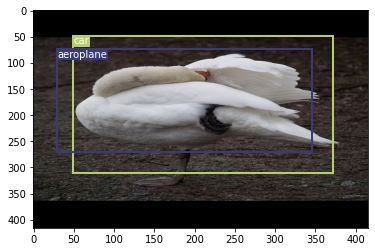

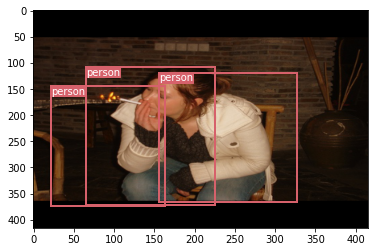

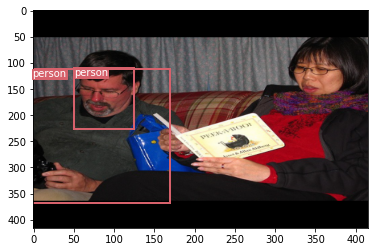

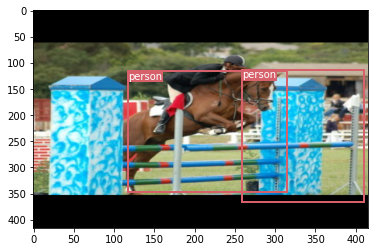

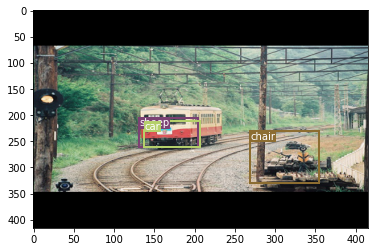

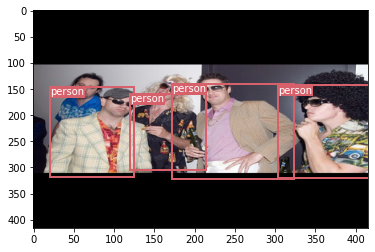

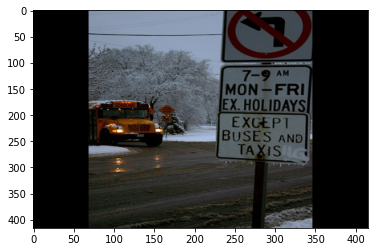

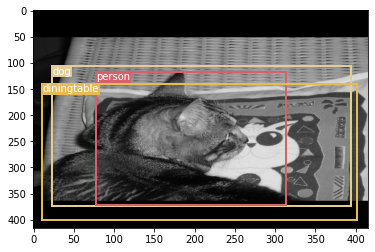

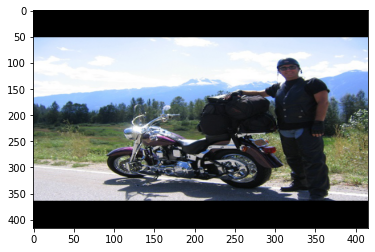

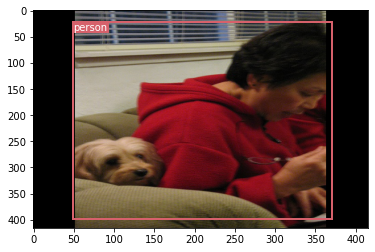

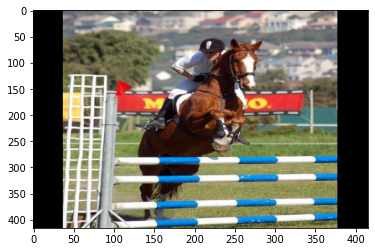

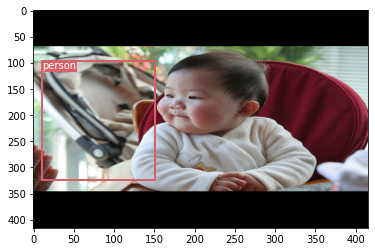

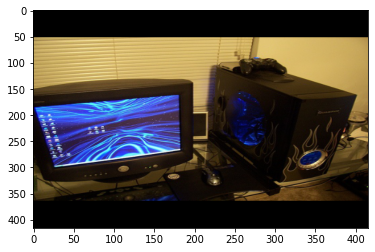

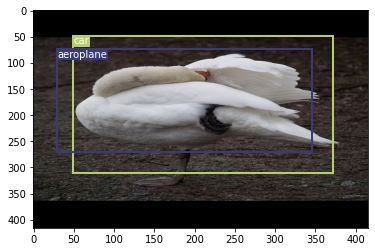

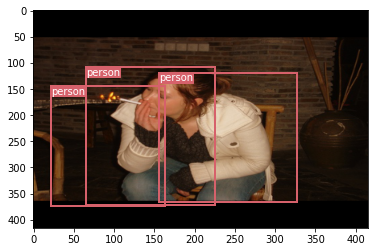

In [ ]:
plot_Test(model, test_loader, 0.6, 0.5, scaled_anchors)

In [ ]:
pred_boxes, true_boxes = get_evaluation_bboxes(
    test_loader,
    model,
    iou_threshold= 0.45,
    anchors=ANCHORS,
    threshold=0.6,
)
mapval = mean_average_precision(
  pred_boxes,
  true_boxes,
  iou_threshold=0.5,
  box_format="midpoint",
  num_classes=20,
)
print(f"MAP: {mapval.item()}")

100%|██████████| 4/4 [00:06<00:00,  1.53s/it]

MAP: 0.05838324502110481


In [56]:
model = YOLOv3(num_classes = 20).to(DEVICE)
checkpoint = torch.load("Weights/checkpoint.pth.tar", map_location=DEVICE)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

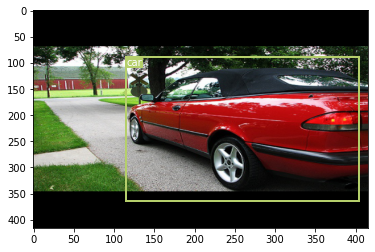

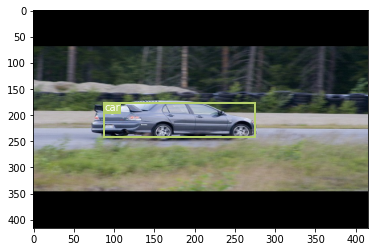

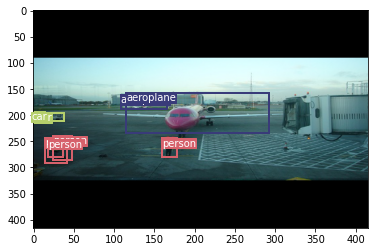

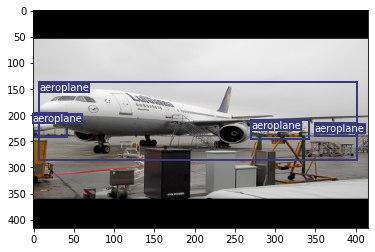

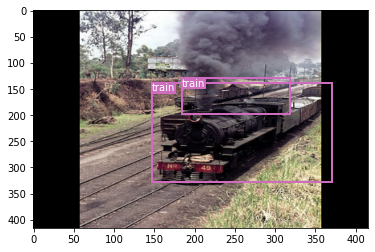

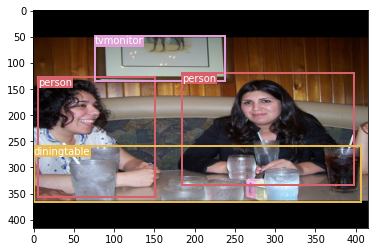

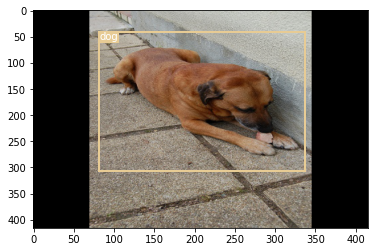

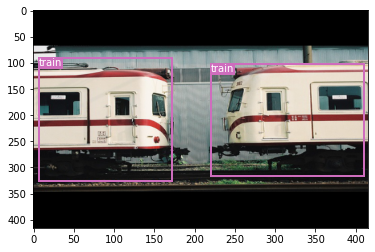

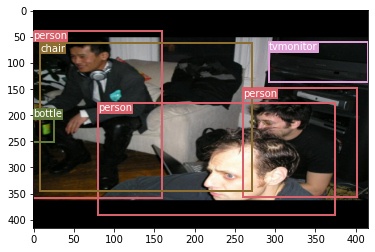

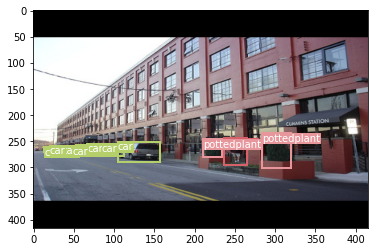

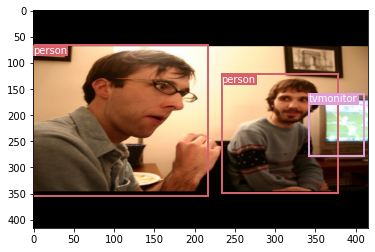

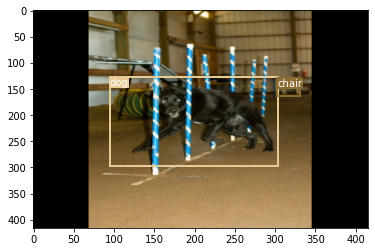

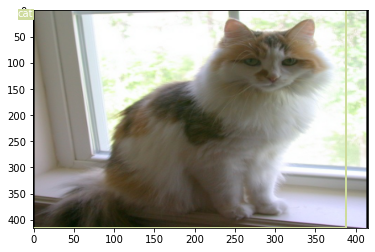

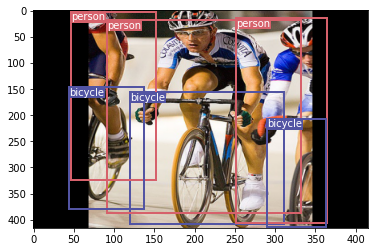

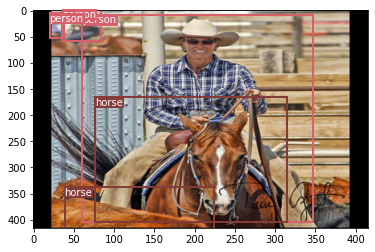

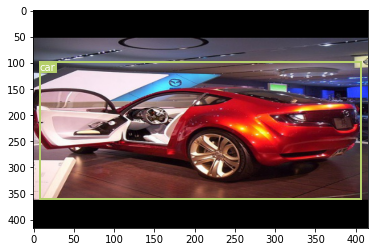

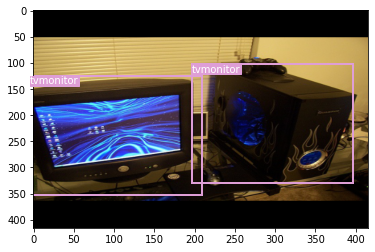

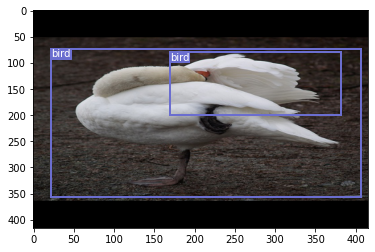

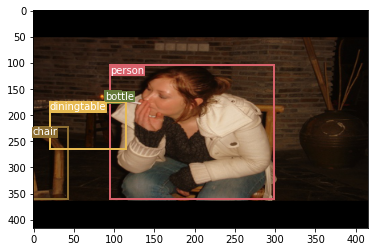

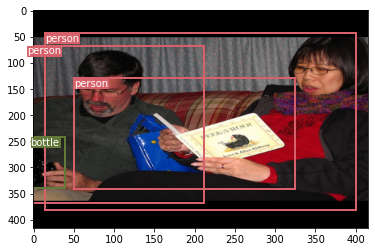

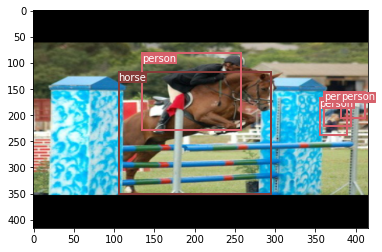

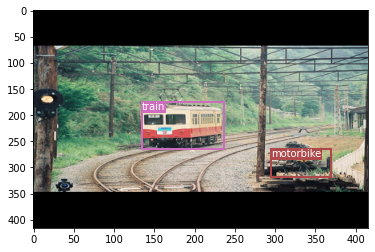

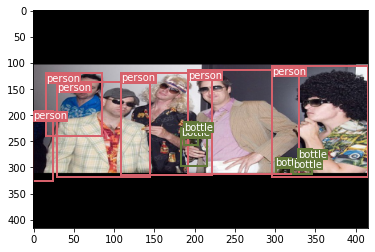

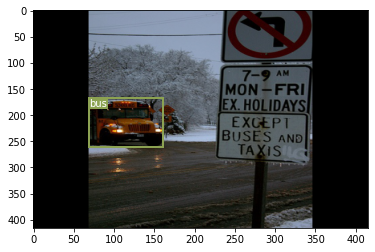

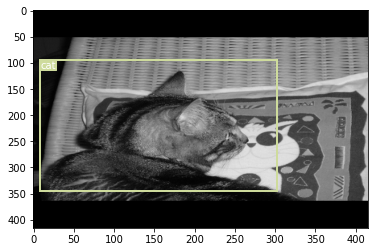

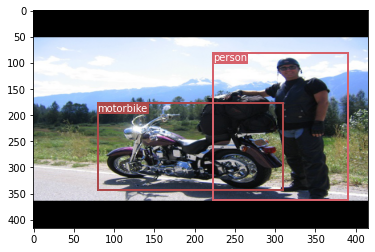

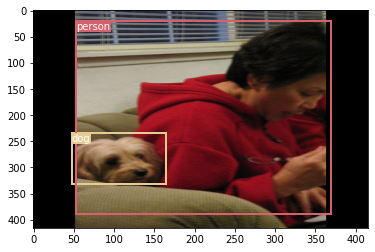

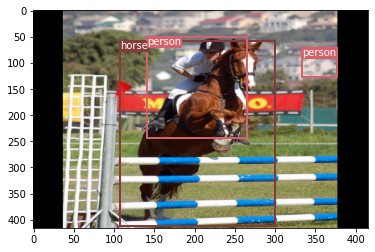

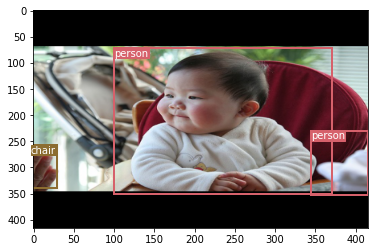

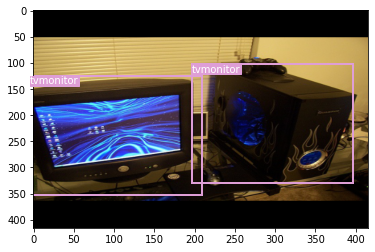

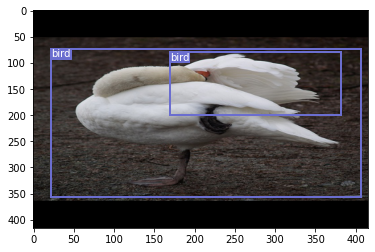

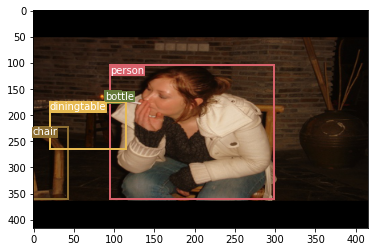

In [57]:
plot_Test(model, test_loader, 0.6, 0.5, scaled_anchors)

In [58]:
pred_boxes, true_boxes = get_evaluation_bboxes(
    test_loader,
    model,
    iou_threshold= 0.45,
    anchors=ANCHORS,
    threshold=0.6,
)
mapval = mean_average_precision(
  pred_boxes,
  true_boxes,
  iou_threshold=0.5,
  box_format="midpoint",
  num_classes=20,
)
print(f"MAP: {mapval.item()}")

100%|██████████| 4/4 [00:07<00:00,  2.00s/it]


MAP: 0.8553426861763
